In [115]:
import dataframe_image as dfi
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
import spacy
import string
import tqdm
import warnings
import matplotlib
import matplotlib.pyplot as plt

In [116]:
warnings.filterwarnings('ignore')

In [117]:
matplotlib.rcParams['figure.dpi'] = 180  # Setting visual DPI for notebook
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 5.5}
matplotlib.rc('font', **font)

In [118]:
df = pd.read_csv('temp_all.csv')

# Data Cleaning

### Data Transformations

In [119]:
# revenue is double counting
# why is it two times the length of the dataframe
    # right now: if million or billion in sector or type, then need to append that to the revenue and leave the sector or the type as other/unknown

In [120]:
# Year
#  'Company - Private',
#  'Company - Public',
#  'Contract',
#  'Government',
#  'Nonprofit Organization',
#  'Self-employed',
# Also Year Founded has Unknown

In [121]:
def handle_incorrect_categories(df):
    '''
    Some data points have revenue information in company type.
    '''
    list_wrong_types = ['$1 to $5 million (USD)',
                        '$5 to $10 million (USD)',
                        'Less than $1 million (USD)'
                        ]
    list_wrong_sectors = [ '$1 to $2 billion (USD)',
                            '$1 to $5 million (USD)',
                            '$10 to $25 million (USD)',
                            '$10+ billion (USD)',
                            '$100 to $500 million (USD)',
                            '$50 to $100 million (USD)',
                            'Less than $1 million (USD)'
                        ]
    list_wrong_years  = [
                        'Company - Private',
                        'Company - Public',
                        'Contract',
                        'Government',
                        'Nonprofit Organization',
                        'Self-employed',
                        ]
    for wrong in list_wrong_types:
        df.loc[df['Company Type']==wrong, 'Company Revenue'] = wrong
        df.loc[df['Company Type']==wrong, 'Company Type'] = 'Unknown / Non-Applicable'
    for wrong in list_wrong_sectors:
        df.loc[df['Company Sector']==wrong, 'Company Revenue'] = wrong
        df.loc[df['Company Sector']==wrong, 'Company Sector'] = 'Unknown / Non-Applicable'
    for wrong in list_wrong_years:
        df.loc[df['Year Founded']==wrong, 'Company Type'] = wrong
        df.loc[df['Year Founded']==wrong, 'Year Founded'] = -1
    return df

In [122]:
def handle_missing(df):
    '''
    Handles missing values according to each columns Other / Unknown values.
    '''
    df.loc[df['Company Type']=='-1', 'Company Type'] = 'Unknown / Non-Applicable'
    df['Company Type'] = df['Company Type'].fillna('Unknown / Non-Applicable')
    df.loc[df['Company Sector']=='-1', 'Company Sector'] = 'Unknown / Non-Applicable'
    df['Company Sector'] = df['Company Sector'].fillna('Unknown / Non-Applicable')
    df.loc[df['Company Revenue']=='-1', 'Company Revenue'] = 'Unknown / Non-Applicable'
    df['Company Revenue'] = df['Company Revenue'].fillna('Unknown / Non-Applicable')
    df.loc[df['Company Industry']=='-1', 'Company Industry'] = 'Unknown / Non-Applicable'
    df['Company Industry'] = df['Company Industry'].fillna('Unknown / Non-Applicable')
    df.loc[df['Company Size']=='-1', 'Company Size'] = 'Unknown'
    df['Company Size'] = df['Company Size'].fillna('Unknown')
    df.loc[df['Year Founded']=='-1', 'Year Founded'] = -1
    df.loc[df['Year Founded']=='Unknown', 'Year Founded'] = -1
    df['Year Founded'] = df['Year Founded'].fillna(-1)
    df['Rating'] = df['Rating'].fillna(-1)

    return df[df['Salary'].notnull()]

In [123]:
def consolidate_size(df):
    '''
    Certain labels are differentiated due to lower case 'employee' versus capitalized 'Employee'.
    '''
    df.loc[df['Company Size'] == '1 to 50 employees', 'Company Size'] = '1 to 50 Employees'
    df.loc[df['Company Size'] == '10000+ employees', 'Company Size'] = '10000+ Employees'
    df.loc[df['Company Size'] == '1001 to 5000 employees', 'Company Size'] = '1001 to 5000 Employees'
    df.loc[df['Company Size'] == '201 to 500 employees', 'Company Size'] = '201 to 500 Employees'
    df.loc[df['Company Size'] == '5001 to 10000 employees', 'Company Size'] = '5001 to 10000 Employees'
    df.loc[df['Company Size'] == '501 to 1000 employees', 'Company Size'] = '501 to 1000 Employees'
    df.loc[df['Company Size'] == '51 to 200 employees', 'Company Size'] = '51 to 200 Employees'

    return df

In [124]:
def convert_salary(df):
    '''
    Replaces job salaries with numeric values, handles salaries on hourly basis and annual basis. Assumes a 2080 hour work year.
    '''
    df = df[df['Salary'] != '-1']
    df['Hourly'] = df['Salary'].apply(lambda x: 1 if 'Per Hour' in x else 0)
    df['Employer Provided'] = df['Salary'].apply(lambda x: 1 if 'Employer Provided Salary:' in x else 0)
    df['Glassdoor Estimated'] = df['Salary'].apply(lambda x: 1 if '(Glassdoor est.)' in x else 0)
    salaries = df['Salary'].apply(lambda x: x.replace('(Glassdoor est.)', '').replace('Employer Provided Salary:', '').replace('(Employer est.)', '').replace('Per Hour', '').replace('()', '').replace(' - ', '-').replace('$', '').replace('K', '').strip())
    df['Lower Bound Salary'] = salaries.apply(lambda x: int(x.split('-')[0]))
    df['Upper Bound Salary'] = salaries.apply(lambda x: int(x.split('-')[-1]))
    df['Average Salary'] = (df['Lower Bound Salary'] + df['Upper Bound Salary']) / 2
    df['Lower Bound Salary'] = df.apply(lambda x: x['Lower Bound Salary'] * 2.080 if x['Hourly'] == 1 else x['Lower Bound Salary'], axis=1)  # Have to do df.apply because using two separate cols
    df['Upper Bound Salary'] = df.apply(lambda x: x['Upper Bound Salary'] * 2.080 if x['Hourly'] == 1 else x['Upper Bound Salary'], axis=1)
    df['Average Salary'] = df.apply(lambda x: x['Average Salary'] * 2.080 if x['Hourly'] == 1 else x['Average Salary'], axis=1)
    return df

In [125]:
def nunique_values_visual(df):
    '''
    Visualizes the number of unique values for each object data type column as a Pandas DataFrame.
    '''
    list_n_unique = []
    for col in df.select_dtypes('object').columns:
        list_n_unique.append(df[col].nunique())
    return pd.DataFrame(list_n_unique, columns=['Unique Values'], index=df.select_dtypes('object').columns)

In [126]:
def clean_locations(df):
    '''
    Converts the locations to states, remote, or country.
    Full state names to abbreviations:
        https://gist.github.com/rogerallen/1583593
    '''
    # If there is a comma in the value, then need to extract the state.
    # If remote, keep remote
    # If United States, keep United States
    locations = []
    us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",}
    df['Job Location'] = df['Job Location'].fillna('Remote')
    df.loc[df['Job Location'] == 'New York State', 'Job Location'] = 'New York State, NY'
    for state in df['Job Location']:
        if ',' not in state:
            if state in us_state_to_abbrev.keys():
                locations.append(us_state_to_abbrev[state])
            else:  # Remote
                locations.append(state)
        else:  # Comma in text
            locations.append(state.split(', ')[-1])
    df['Job State'] = locations

    return df

In [127]:
def group_locations(df):
    '''
    States are grouped together based on:
    https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States#Census_Bureau-designated_regions_and_divisions
    Will be grouped into 4 total regions
    '''
    df = clean_locations(df)
    regions_to_states = {
    'South': ['WV', 'DC', 'MD', 'VA',
              'KY', 'TN', 'NC', 'MS',
              'AR', 'LA', 'AL', 'GA', 'SC',
              'FL', 'DE'],
    'Southwest': ['AZ', 'NM', 'OK', 'TX'],
    'West': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT',
             'WY', 'UT', 'CO', 'AK', 'HI'],
    'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN','IA', 
    'MO', 'WI', 'IL', 'MI', 'IN', 'OH'],
    'Northeast': ['ME', 'VT', 'NY', 'NH', 'MA', 'RI', 'CT', 'NJ', 'PA'],
    'Remote/Other': ['Remote', 'United States']
    }
    states_to_regions = {value: key for key in regions_to_states for value in regions_to_states[key]}
    df['Job State'] = df['Job State'].map(states_to_regions)

    return df

In [128]:
def convert_year_founded(df, current_year):
    '''
    Convert year founded to age of company by taking the difference between the year founded and the current year.
    '''
    df['Company Age'] = df['Year Founded'].apply(lambda x: x if x == -1 else current_year - int(x))

    return df

In [129]:
def higher_education(df):
    '''
    Takes job description and determines if higher education (Masters, PhD, PostDoc are mentioned.)
    '''
    education  = ["MSc","PhD", "Master", "Doctorate", "Postdoc"]
    edu_req = []
    for desc in df['Job Description']:
        if any(level.lower() in desc.lower() for level in education):
            edu_req.append('Higher Education')
        else:
            edu_req.append('No Higher Education')
    df['Education Demanded'] = edu_req

    return df

In [130]:
def find_top_skills(df):
    '''
    Finds the tops skills required 
    '''
    languages = ["Python", "C++", "MatLab", "C#", "C++" "JavaScript","Julia", "Pearl", "HTML", "Bash", "Java", "Scala", "SQL", "SAS", "R Studio", "R-Studio", "Swift", "D3", "Shiny", "RShiny"]
    software = ["Excel", "Tableau", "PowerBI", "Power BI", "Business Intelligence", "Data Visualization"]
    big_data  = ["Big Data", "ETL", "Atlas", "Spark", "Hadoop", "Impala", "Cassandra", "Kafka", "HDFS", "HBase", "Hive", "Kubernetes", "Kubeflow", "Airflow", "BigQuery", "MongoDB"]
    cloud = ["AWS", "GCP", "Azure", "Google Cloud", "S3","Redshift","EC2","Lambda", "Route S3","Dynamo"]
    skills = languages + software + big_data + cloud
    skill_count = dict.fromkeys(skills, 0)
    for skill in skills:
        for desc in df['Job Description']:
            if skill.lower() in desc.lower():
                skill_count[skill] += 1
            else:
                pass
    # could collect a column of 1s and 0s, then take a sum of those values
    # could also just do nlp again, but make take longer to process every token.

    return skill_count

In [131]:
def match_skills(df, threshold):
    '''
    Matches job description skills demanded with list of in-demand skills for data scientists. Creates boolean columns for top skills appearing in job descriptions. Threshold set at 1000 apperances of skill.
    '''
    popular_skills = []
    skill_count = dict(sorted(find_top_skills(df).items(), key=lambda item: item[1], reverse=True))
    for key in skill_count:
        if skill_count[key] > 1000:
            popular_skills.append(key)
        else:
            pass
    print(popular_skills)
    for skill in popular_skills:
        df[skill] = df['Job Description'].apply(lambda x: 1 if skill.lower() in x.lower() else 0)
    
    return df

In [132]:
def length_of_desc(df):
    '''
    Returns the length of the job description as a column.
    '''
    df['Description Length'] = df['Job Description'].apply(lambda x: len(x))

    return df

In [133]:
def clean_job_names(df):
    '''
    Engineers name of job to useful feature by extracting labels.
    '''
    level = []
    label = []
    nlp = spacy.load('en_core_web_sm')
    experienced = ['lead','leader', 'principal', 'senior', 'sr', 'iv', 'iii', 'mid']
    entry = ['entry', 'associate', 'assc', 'i', 'ii', 'junior', 'jr']
    
    for index, name in enumerate(df['Job Name']):
        experienced_count = 0
        entry_count = 0
        other_count = 0
        doc = nlp(name)
        # print('Index: ', index)
        name = re.sub(r'[^\w\s]', ' ', name.lower())
        if 'manager' in name.lower():
            label.append('Manager')
        elif 'director' in name.lower():
            label.append('Director')
        elif 'machine learning' in name.lower() or 'ml' in name.lower():
            label.append('Machine Learning Engineer')
        elif 'data engineer' in name.lower():
            label.append('Data Engineer')
        elif 'data scientist' in name:
            label.append('Data Scientist')
        elif 'analyst' in name.lower():
            label.append('Data Analyst')
        else:
            label.append('Other')
        # tokenize
        for token in doc:
            if token.pos_ not in ['PUNCT']:
                if [ele for ele in experienced if(ele == token.text.lower())]:
                    experienced_count += 1
                elif [ele for ele in entry if (ele == token.text.lower())]:
                    entry_count += 1
                else:
                    other_count += 1
            else:
                pass
        if experienced_count != 0:
            level.append('Experienced')
        elif entry_count != 0:
            level.append('Entry Level')
        else:
            level.append('Other')
    df['Job Level'] = level
    df['Job Label'] = label

    return df

In [134]:
def group_company_names(df):
    '''
    Labels if a company is a FAANG company or not.
    '''
    FAANG = ['Facebook', 'Meta', 'Apple', 'Amazon', 'Netflix', 'Google', 'Alphabet']
    faang_or_not = []
    for name in df['Company Name']:
        if [ele for ele in FAANG if (ele.lower() in name.lower())]:
            faang_or_not.append('FAANG')
        else:
            faang_or_not.append('Not FAANG')
    df['FAANG Or Not'] = faang_or_not
    df.drop(columns=['Company Name'], inplace=True)
    
    return df

In [135]:
def group_company_attributes(df):
    '''
    Thinning the number of unique values for company type, industry, and sector. There are many values between industry and sector that overlap.
    Grouping different industries into more defined sectors, will also not use the original sector values which are ambigious at best. For example, 'Business Services' vs 'Accounting' vs 'Insurance', etc.
    '''
    group_to_industry = {
            'Education': ['Colleges & Universities', 'Education', 'K-12 Education', 'Preschool & Child Care', ],

            'Government': ['Aerospace & Defense','Government & Public Administration', 'National Agencies', 'Government', 'Federal Agencies'],

            'Retail': ['Consumer Electronics & Appliances Stores',  'Department, Clothing & Shoe Stores', 'Department, Clothing, & Shoe Stores', 'General Merchandise & Superstores', 'Grocery Stores', 'Home Furniture & Housewares Stores', 'Other Retail Stores', 'Restaurants & Cafes', 'Consumer Product Rental', 'Retail & Wholesale', 'Sporting Goods Stores', 'Wholesale',],

            'Service': ['Advertising & Public Relations',  'Advertising & Marketing', 'Business Consulting', 'Financial Services', 'Grantmaking & Charitable Foundations', 'HR Consulting', 'Hotels & Resorts', 'Human Resources & Staffing', 'Management & Consulting', 'Membership Organizations', 'Nonprofit & NGO', 'Security & Protective', 'Staffing & Outsourcing', 'Staffing & Subcontracting', 'Service', 'Consulting',  'Education Training Services', 'Farm Support Services', 'IT Services','Metals Brokers', 'Religious Organizations', 'Security Services', 'Social Assistance', 'Taxi & Car Services', 'Transportation Management',],

            'Health': [ 'Beauty & Personal Accessories Stores', 'Beauty & Wellness', 'Biotech & Pharmaceuticals', 'Health Care Services & Hospitals', 'Healthcare', 'Pharmaceutical & Biotechnology', 'Health', 'Health, Beauty, & Fitness'],

            'Manufacturing': ['Consumer Product Manufacturing', 'Consumer Products Manufacturing', 'Electronics Manufacturing', 'Food & Beverage Manufacturing', 'Health Care Products Manufacturing', 'Machinery Manufacturing', 'Manufacturing', 'Transportation Equipment Manufacturing', 'Manufacturing',  'Chemical Manufacturing', 'Industrial Manufacturing', 'Logistics & Supply Chain', 'Manufacturing',  'Mining', 'Telecommunications Manufacturing',],

            'Finance': ['Accounting', 'Accounting & Tax',  'Banks & Credit Unions', 'Banking & Lending', 'Lending','Financial Transaction Processing', 'Insurance Agencies & Brokerages', 'Insurance Carriers', 'Investment & Asset Management', 'Finance', 'Brokerage Services', 'Financial Analytics & Research', 'Investment Banking & Asset Management', 'Stock Exchanges', ],

            'Communications': ['Broadcast Media','Cable, Internet & Telephone Providers', 'Telecommunications Services', 'Communications', 'Media & Communication', 'TV Broadcast & Cable Networks', ],

            'Entertainment': ['Arts, Entertainment & Recreation', 'Film Production', 'Gambling', 'Sports & Recreation', 'Video Game Publishing', 'Entertainment', 'Auctions & Galleries', 'Motion Picture Production & Distribution', 'Publishing', 'Video Games',],

            'Technology': [ 'Computer Hardware & Software', 'Computer Hardware Development', 'Enterprise Software & Network Solutions', 'Information Technology', 'Information Technology Support Services', 'Internet & Web Services', 'Research & Development', 'Technology',  'Internet',],

            'Construction / Real Estate': ['Architectural & Engineering Services',  'Building & Personnel Services', 'Real Estate', 'Construction / Real Estate', 'Construction',],
                            
            'Energy & Transportation': ['Airlines, Airports & Air Transportation', 'Automotive Parts & Accessories Stores','Energy & Utilities', 'Shipping & Trucking', 'Energy & Transportation',  'Energy', 'Gas Stations', 'Travel Agencies', 'Trucking','Utilities',],
            
            'Unknown / Non-Applicable': ['Unknown / Non-Applicable']
        }

    industry_to_group = {value: key for key in group_to_industry for value in group_to_industry[key]}
    df['Grouped Company Industry'] = df['Company Industry'].map(industry_to_group)
    df.loc[(df['Grouped Company Industry']=='Construction / Real Estate') | (df['Grouped Company Industry']=='Communications') | (df['Grouped Company Industry']=='Education') | (df['Grouped Company Industry']=='Entertainment'), 'Company Industry'] = 'Other'

    df.loc[(df['Company Type'] != 'Company - Public') & (df['Company Type'] != 'Company - Private'), 'Company Type'] = 'Other'
    df.drop(columns=['Company Sector'], inplace=True)  # Sector and Industry are largely redundant

    return df

In [136]:
def ordinal_categories(df):
    '''
    Converts company revenue and company size to ordinal values. 
    '''
    revenue_ord = {
                "$10+ billion (USD)": 12, 
                "$5 to $10 billion (USD)": 11,
                "$2 to $5 billion (USD)":10, 
                "$1 to $2 billion (USD)":9,
                "$500 million to $1 billion (USD)": 8,
                "$100 to $500 million (USD)": 7,
                "$50 to $100 million (USD)": 6,
                "$25 to $50 million (USD)": 5,
                "$10 to $25 million (USD)": 4,
                "$5 to $10 million (USD)": 3,
                "$1 to $5 million (USD)": 2,
                "Less than $1 million (USD)": 1,
                "Unknown / Non-Applicable": 0
                }
    size_ord = {"10000+ Employees":7,
                "5001 to 10000 Employees": 6,
                "1001 to 5000 Employees": 5,
                "501 to 1000 Employees": 4,
                "201 to 500 Employees": 3,
                "51 to 200 Employees":2,
                "1 to 50 Employees":1,
                "Unknown":0
                }
    skills_ord = {
                "None": 0,
                "Entry": 1,
                "Medium": 2,
                "Expert": 3
                }
    job_level = {
                "Other": 0,
                "Entry Level": 1,
                "Experienced": 2
                }
    df['Company Revenue'] = df['Company Revenue'].map(revenue_ord)
    df['Company Size'] = df['Company Size'].map(size_ord)
    df['Skill Requirement'] = df['Skill Requirement'].map(skills_ord)
    df['Job Level'] = df['Job Level'].map(job_level)
    
    return df

In [137]:
def clean_data(df):
    '''
    Calls all functions for data cleaning in a single wrapper function.
    '''
    df = handle_incorrect_categories(df)
    df = handle_missing(df)
    df = consolidate_size(df)
    df = convert_salary(df)
    df = group_locations(df)
    df = convert_year_founded(df, 2022)
    df = higher_education(df)
    df = match_skills(df, 1000)
    df = length_of_desc(df)
    df = clean_job_names(df)
    df = group_company_names(df)
    df = group_company_attributes(df)
    
    return df

In [138]:
df = clean_data(df)

['Python', 'SQL', 'Excel', 'AWS', 'Spark', 'Tableau', 'Scala', 'Big Data', 'Data Visualization']


In [139]:
set(df['Company Revenue'])

{'$1 to $2 billion (USD)',
 '$1 to $5 million (USD)',
 '$10 to $25 million (USD)',
 '$10+ billion (USD)',
 '$100 to $500 million (USD)',
 '$2 to $5 billion (USD)',
 '$25 to $50 million (USD)',
 '$5 to $10 billion (USD)',
 '$5 to $10 million (USD)',
 '$50 to $100 million (USD)',
 '$500 million to $1 billion (USD)',
 'Less than $1 million (USD)',
 'Unknown / Non-Applicable'}

In [140]:
# df['Salary Range'] = df['Upper Bound Salary'] - df['Lower Bound Salary']
# df['Salary Range'].mean()

In [141]:
g = nunique_values_visual(df)
g

,Unique Values
Job Name,704
Salary,617
Job Description,1364
Job Location,347
Company Size,8
Year Founded,144
Company Type,3
Company Industry,91
Company Revenue,13
Job State,6


# Data Visualizations (Exploration and used for exploring different data transformations)

<AxesSubplot:xlabel='Average Salary', ylabel='Density'>

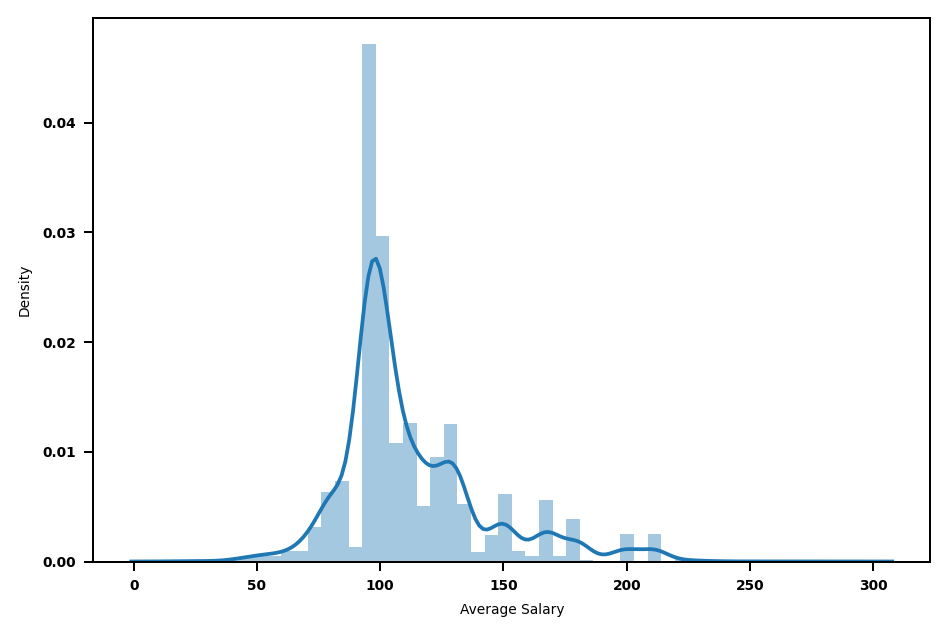

In [142]:
sns.distplot(df['Average Salary'])

In [143]:
def remove_outliers(df):
    '''
    Removes outliers using the Interquartile Range Method.
    '''
    q25, q75 = np.percentile(df['Average Salary'], 25), np.percentile(df['Average Salary'], 75)  # Get quartile values
    iqr = q75 - q25  # Get IQR
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off  # Establish min max values
    
    return df[(df['Average Salary'] > lower) & (df['Average Salary'] < upper)] 

In [144]:
df = remove_outliers(df)

<AxesSubplot:>

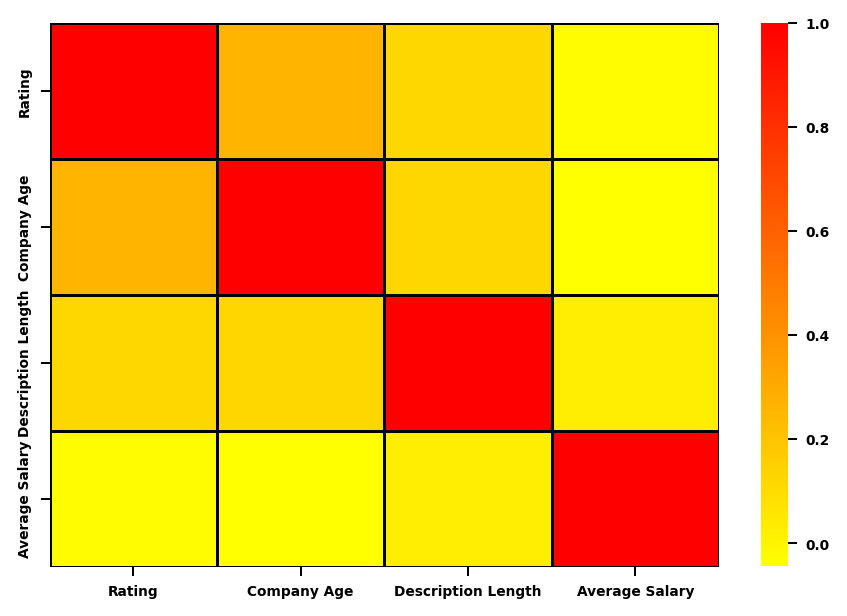

In [145]:
# Looking at numerical variables engineered
sns.heatmap(df[['Rating', 'Company Age', 'Description Length', 'Average Salary']].corr(), cmap='autumn_r', linewidths=1, linecolor='black')

# probably do not use lower bound or higher bound salary in model since they are just used for engineering average.

In [146]:
df.select_dtypes('object').columns
cat_cols = ['Company Size', 'Company Type', 'Grouped Company Industry', 'Company Revenue', 'Job State', 'Education Demanded', 'Job Level', 'Job Label', 'FAANG Or Not', ]

In [147]:
def count_plots(df, cols):
    '''
    Displays distributions of different variables for a DataFrame.
    '''
    df_temp = df[cols]
    for col in df_temp.columns:
        sns.countplot(df[col], edgecolor='black', order=df[col].value_counts().index)
        plt.title('Value Counts of %s' %(col))
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

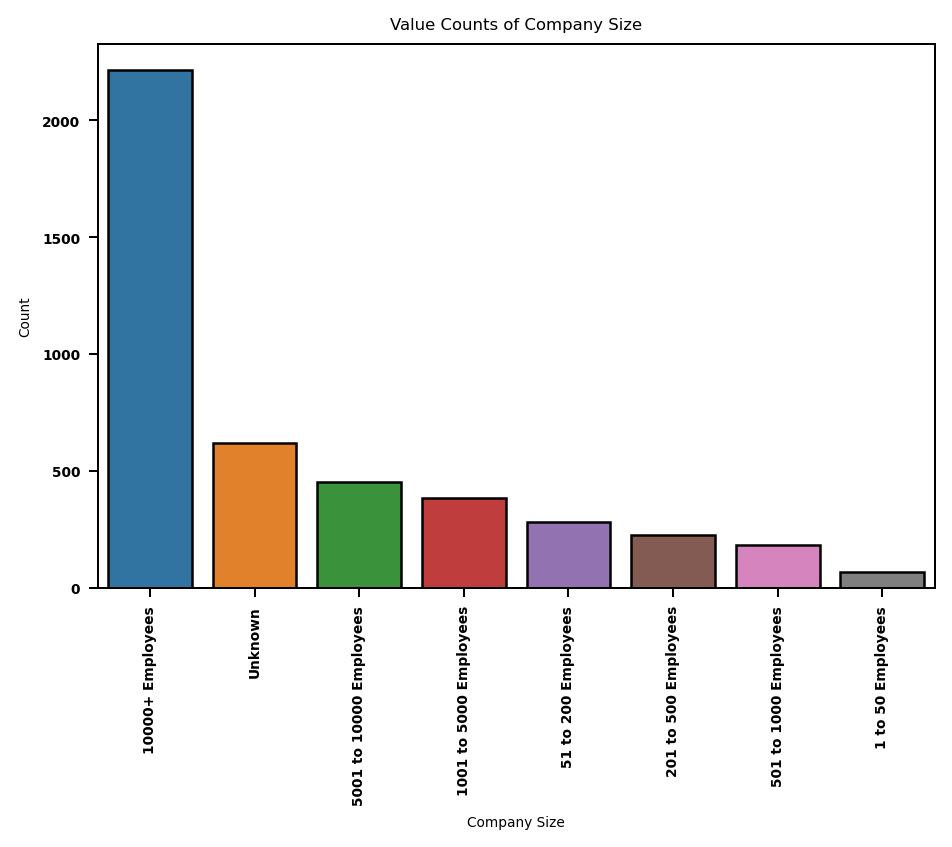

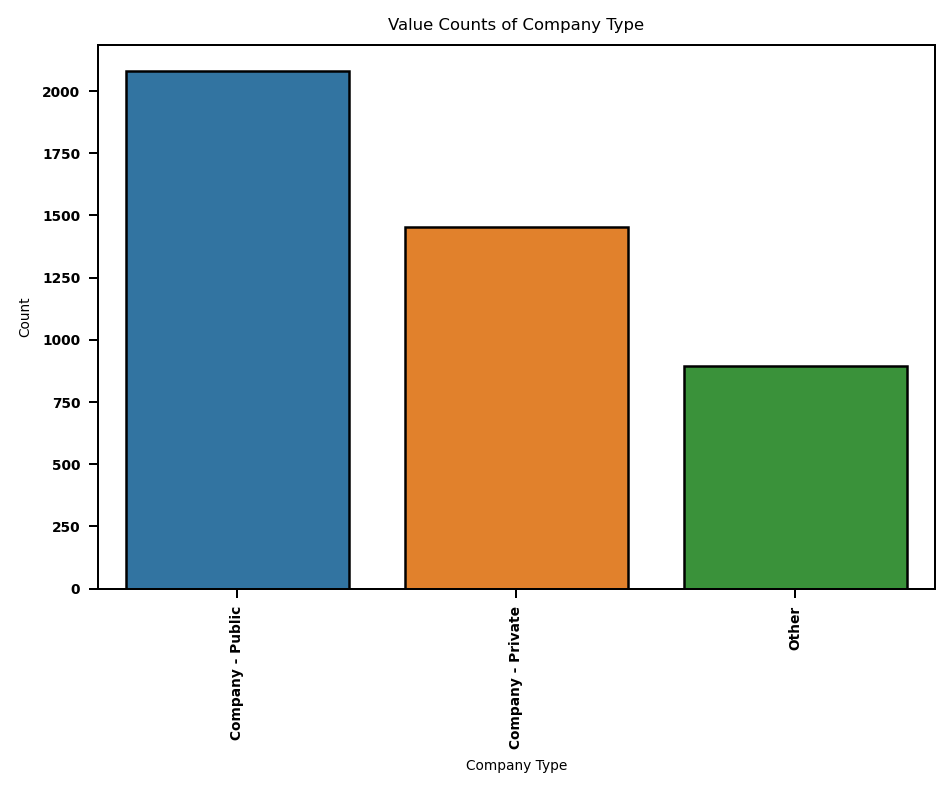

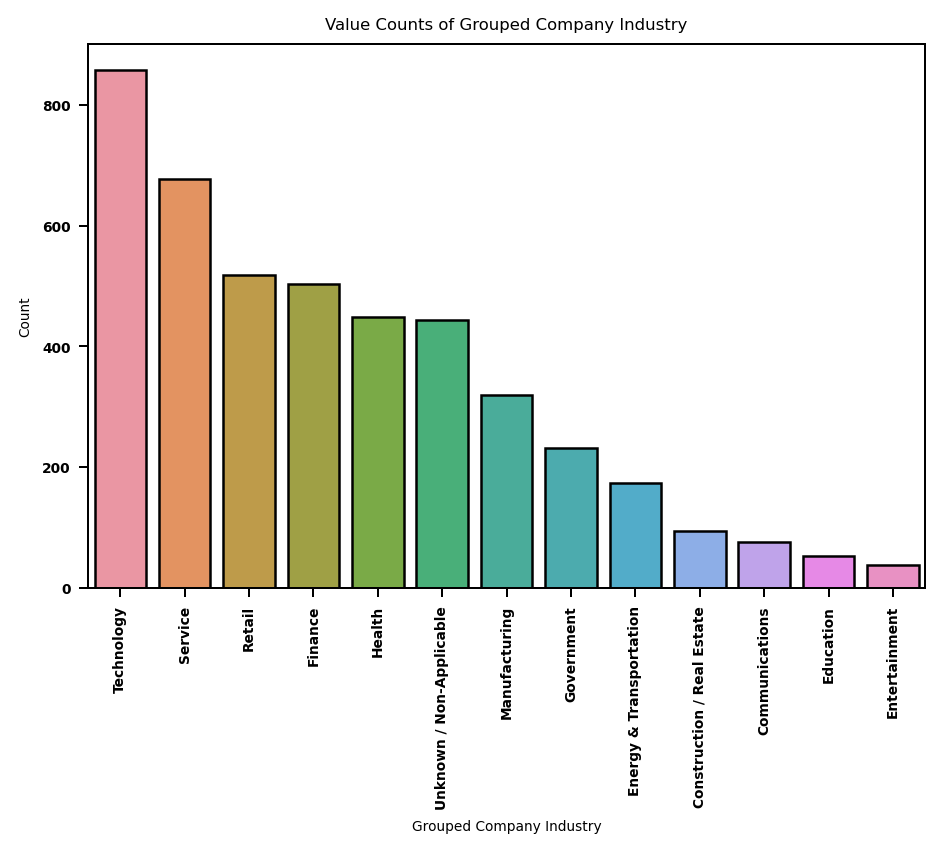

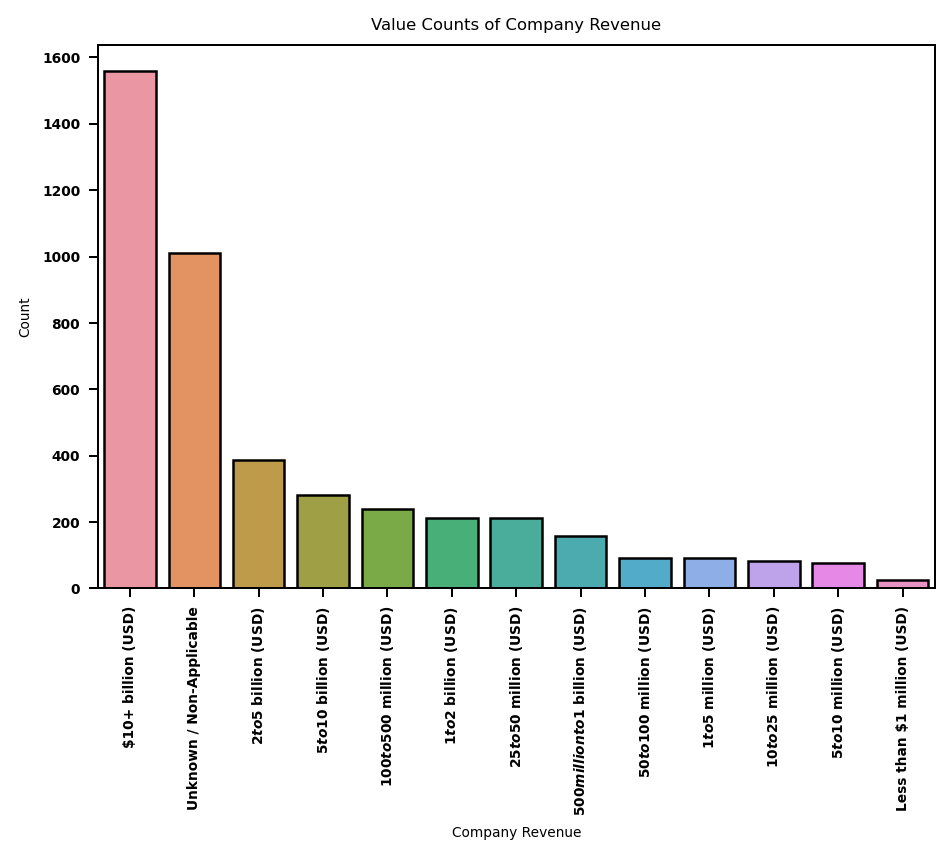

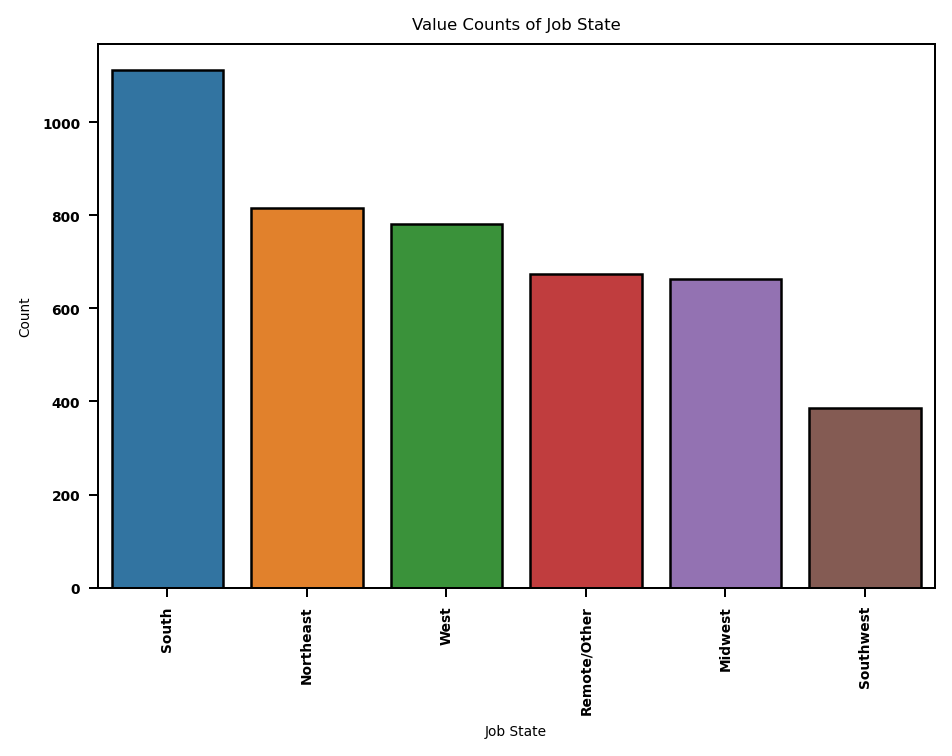

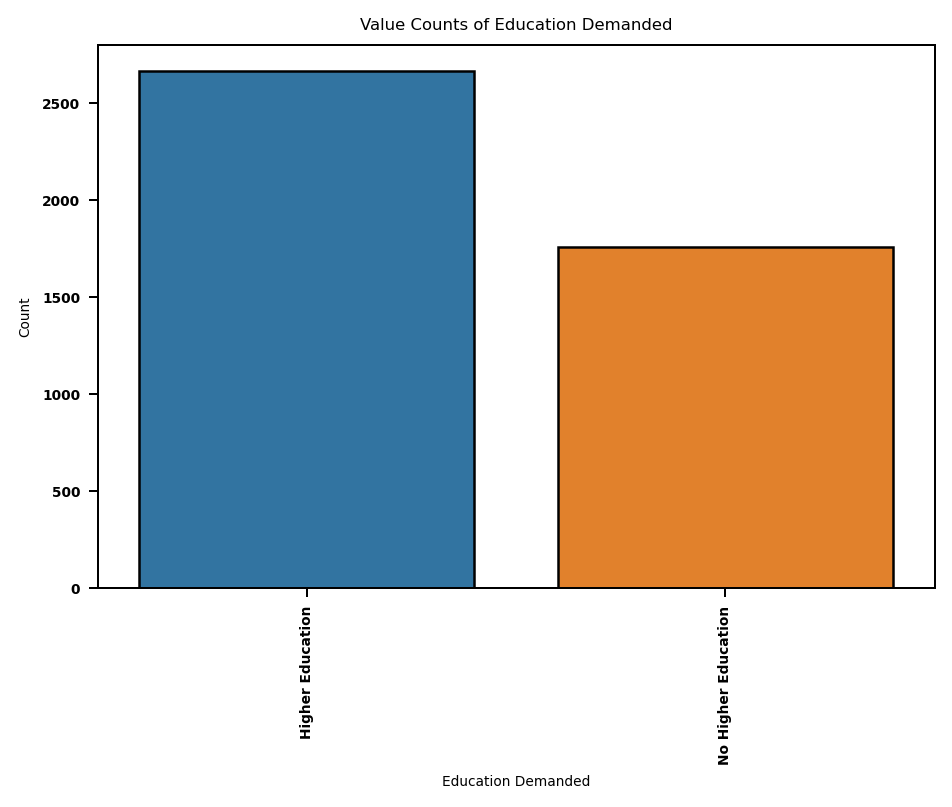

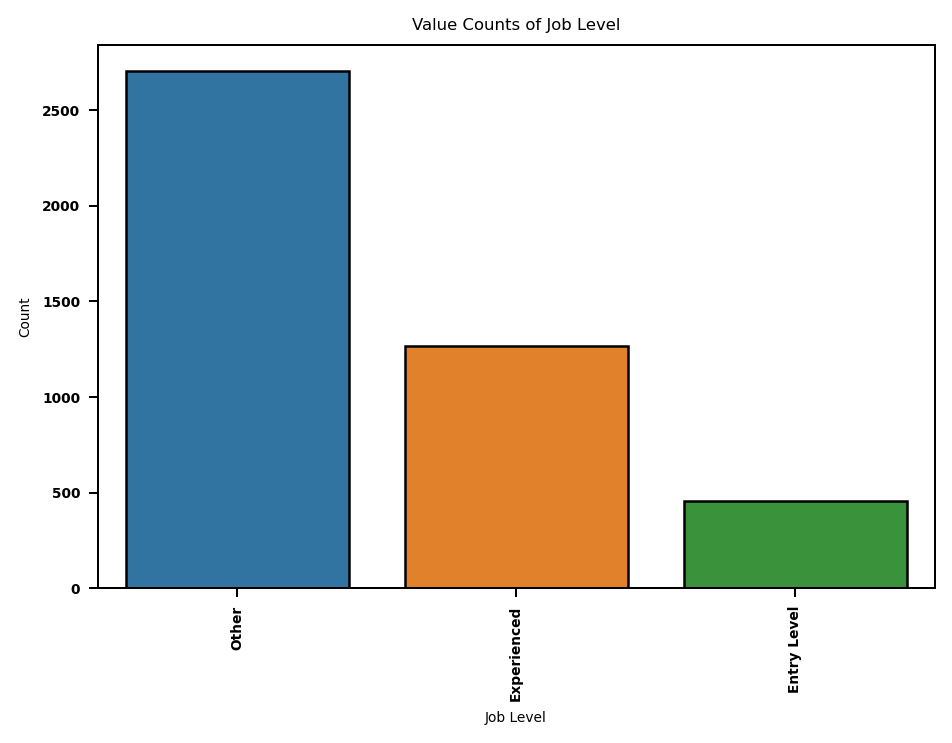

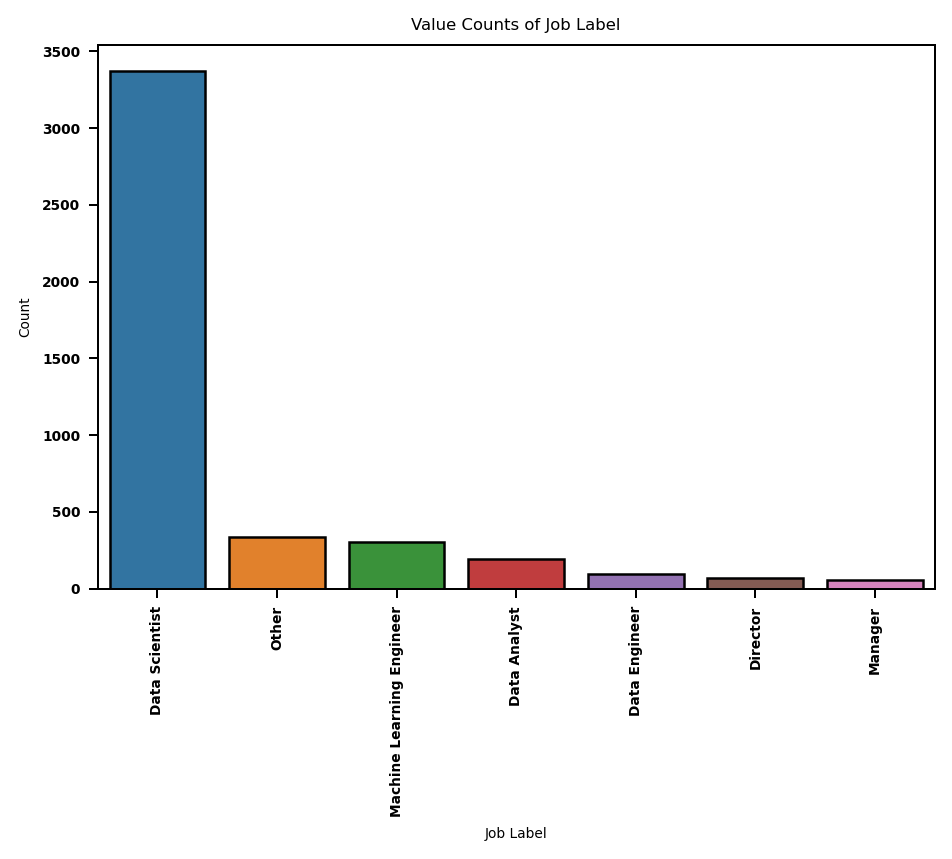

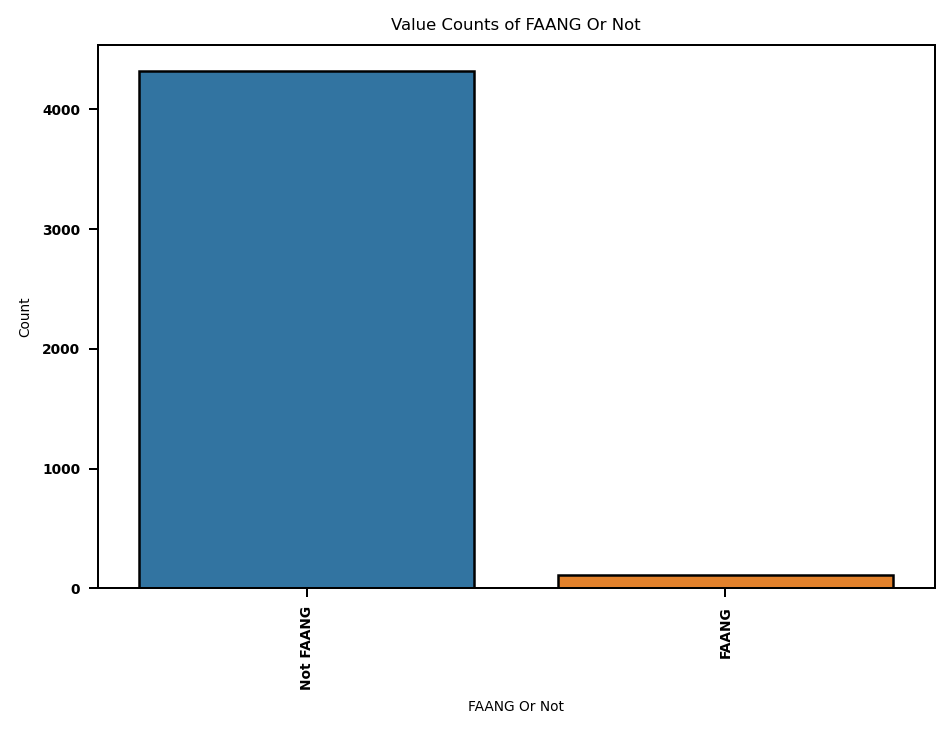

In [148]:
count_plots(df, cat_cols)

In [149]:
def ordered_count_plot(df, cols):
    '''
    Returns visual for a given column and the average salaries for each value of the column.  
    '''
    for col in df[cols].columns:
        averages = {}
        values = df[col].value_counts().index.to_list()
        for value in values:
            averages[value] = (df[df[col] == value]['Average Salary'].mean())
        temp = pd.DataFrame(averages.items(), columns=[str(col), 'Average Salary'])
        temp = temp.sort_values(by='Average Salary', ascending=False)
        sns.barplot(x=temp[str(col)], y=temp['Average Salary'], edgecolor='black')
        plt.title('Average Salaries for %s' %(col))
        plt.xlabel(col)
        plt.ylabel('Average Salary')
        plt.xticks(rotation=90)
        plt.show()

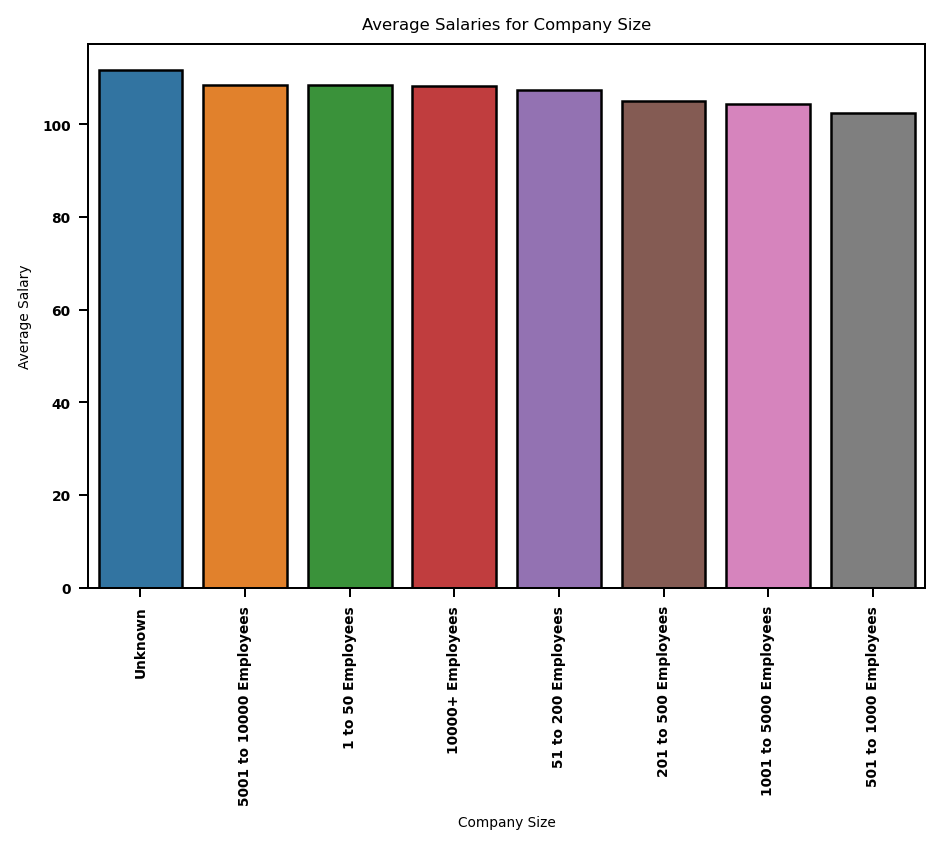

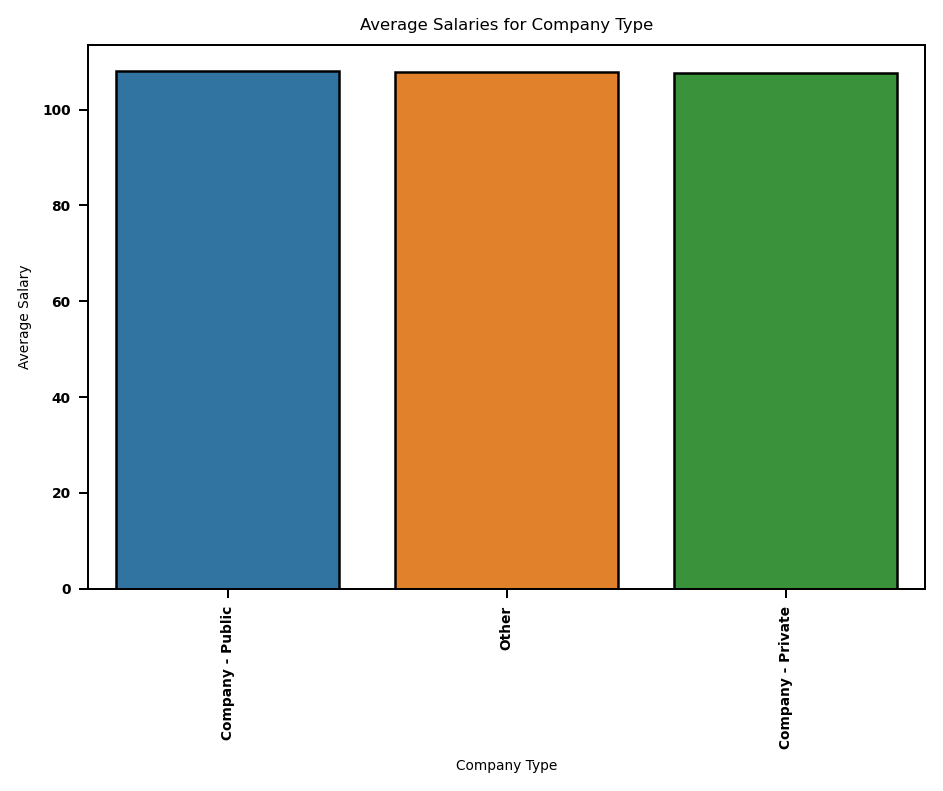

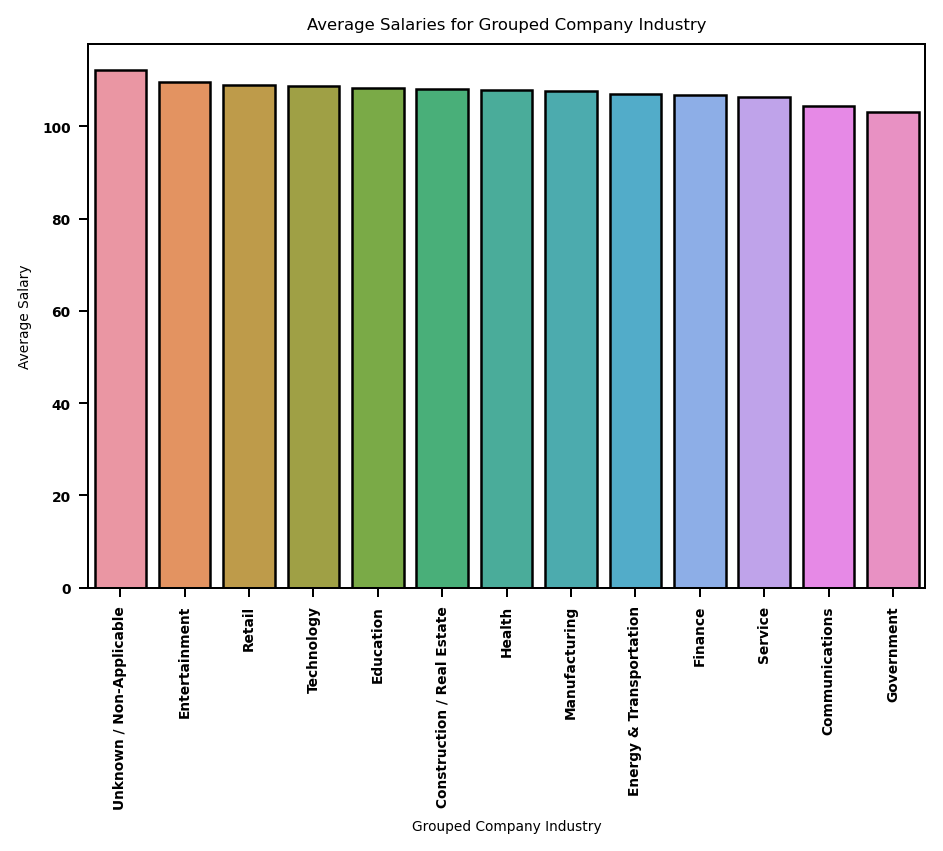

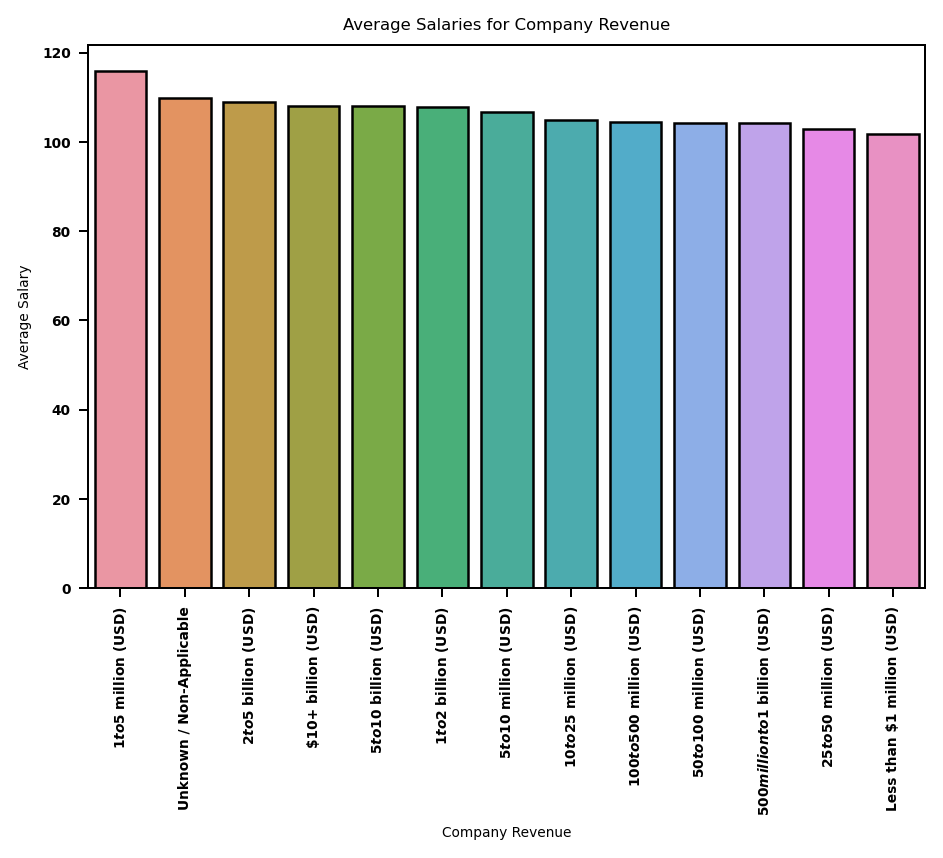

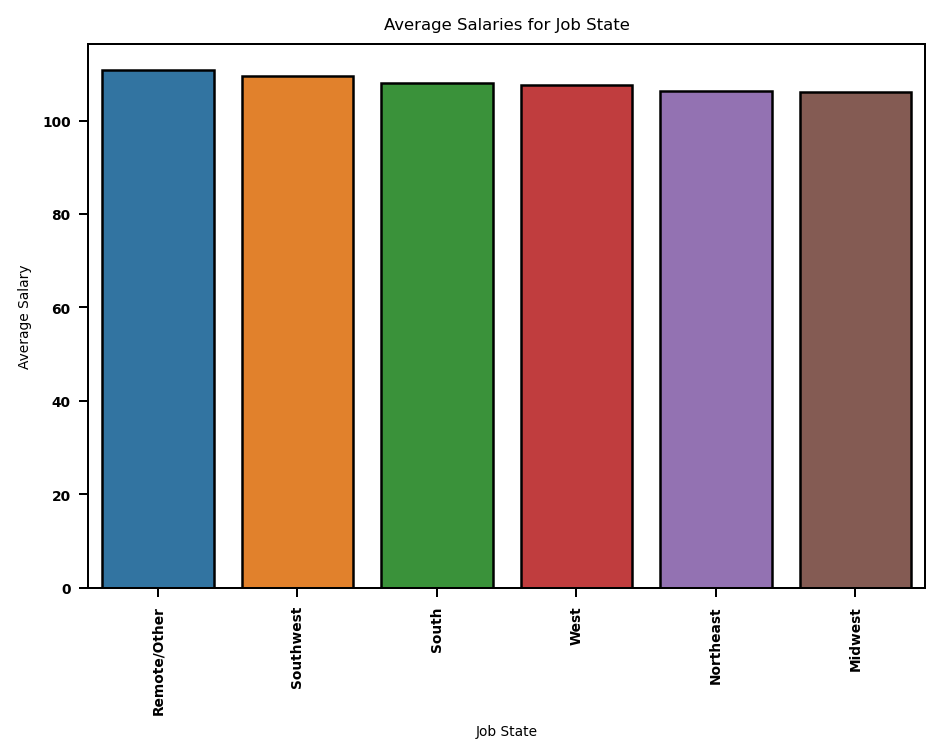

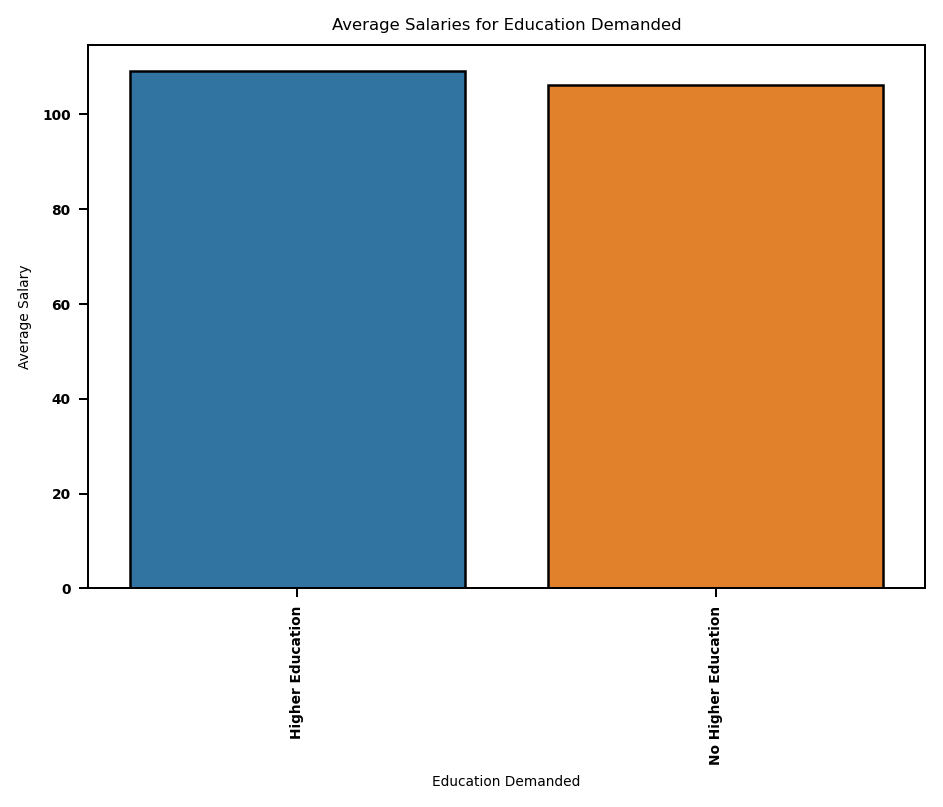

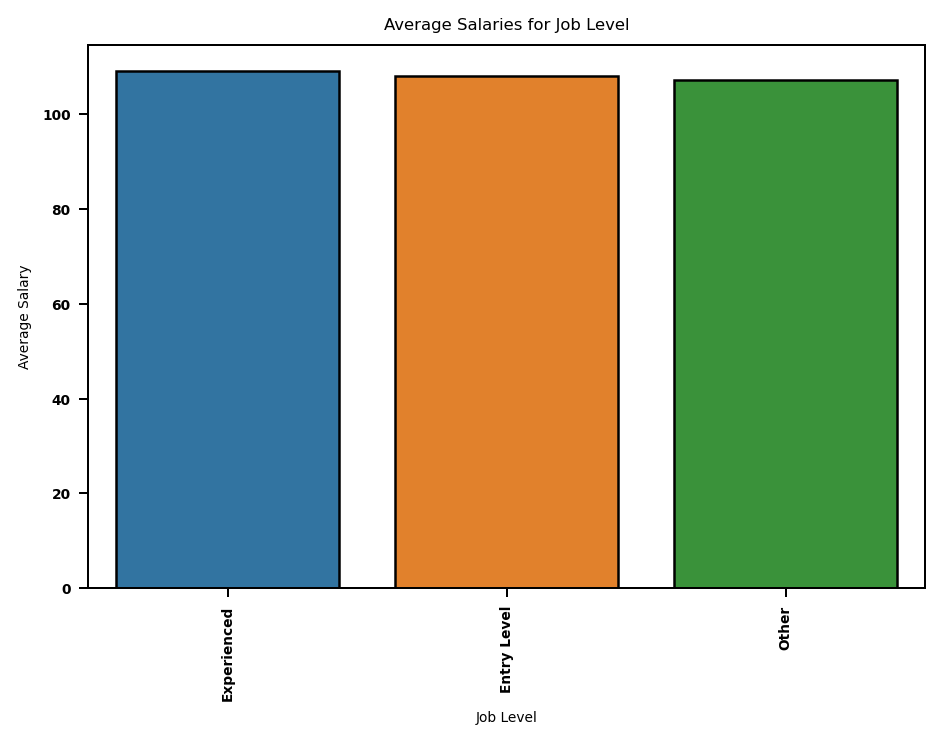

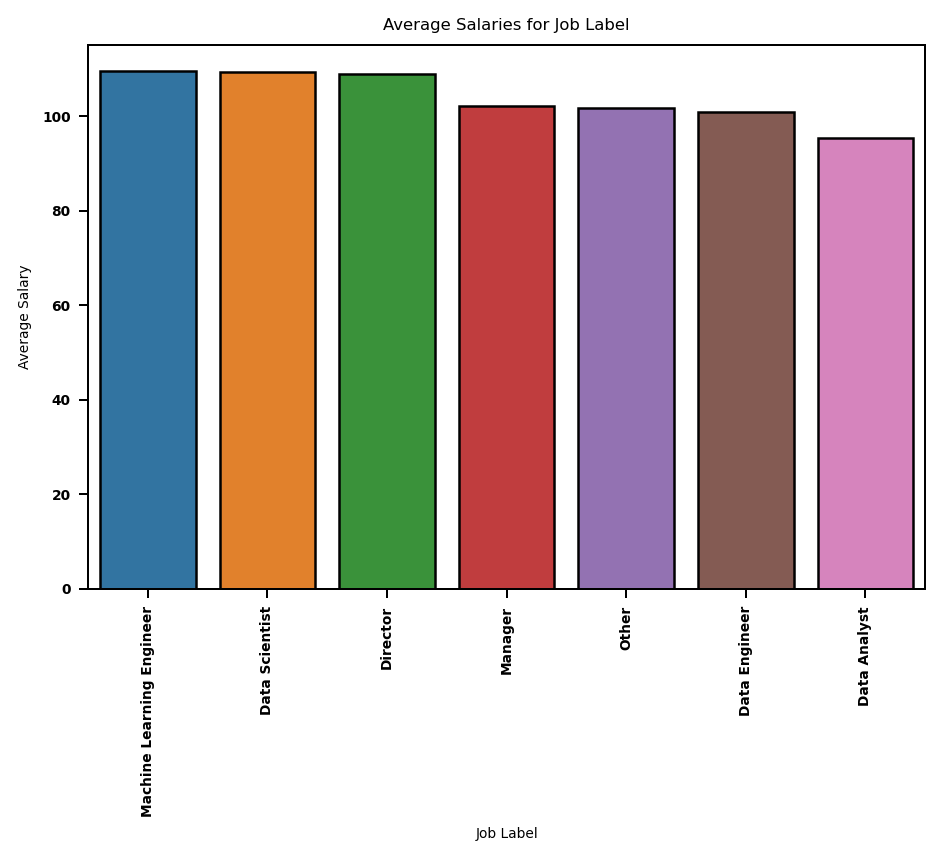

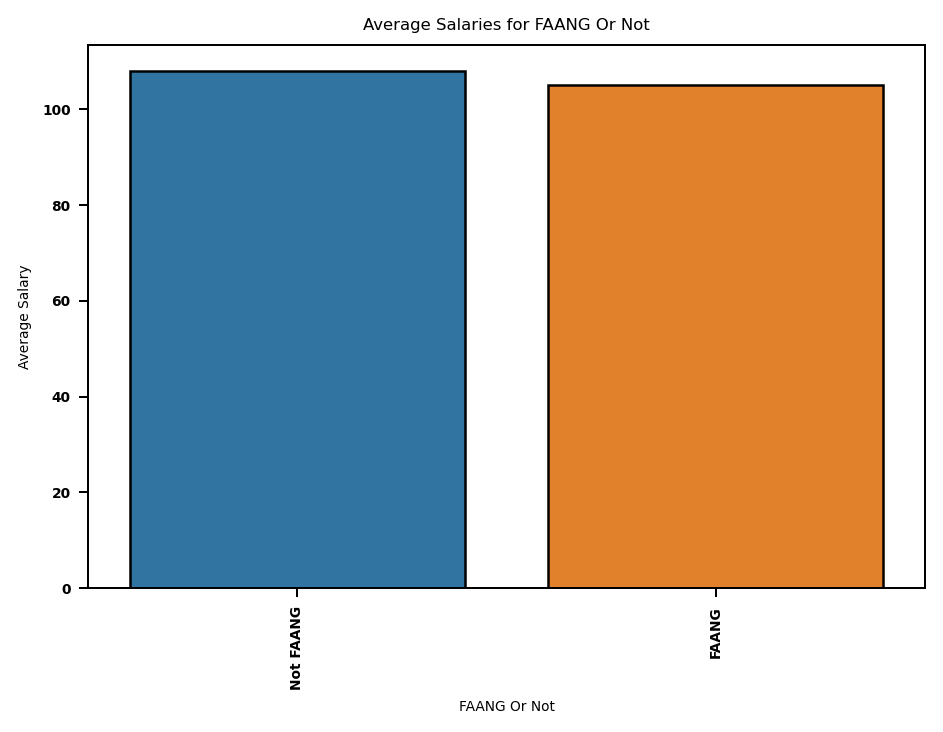

In [150]:
ordered_count_plot(df, cat_cols)

In [151]:
def create_pivot_visual(df, index, descend: bool):
    '''
    Creates a pivot table for a given set of indices for average salaries.
    '''
    if bool:
        return pd.pivot_table(df, index=index, values=['Average Salary']).sort_values('Average Salary', ascending=False)
    else:
        return pd.pivot_table(df, index=index, values=['Average Salary'])

In [152]:
label_level_sals = create_pivot_visual(df, ['Job Label', 'Job Level'], False)

In [153]:
label_level_sals_png = label_level_sals.style.background_gradient()

In [154]:
dfi.export(label_level_sals_png, 'label_level_sals.png')

In [155]:
create_pivot_visual(df, ['Job Label', 'Job State'], descend=False)

Average Salary
Job Label                 Job State                   
Director                  Remote/Other      115.441176
Machine Learning Engineer Remote/Other      114.050000
Director                  South             113.944444
Data Scientist            Remote/Other      111.659628
Data Engineer             West              111.421053
Director                  Midwest           111.250000
Machine Learning Engineer Midwest           111.229167
                          Southwest         110.974576
Data Scientist            Southwest         110.627797
Machine Learning Engineer Northeast         110.131579
Data Scientist            South             109.657667
                          West              109.387818
Manager                   Remote/Other      108.500000
                          Northeast         108.117647
Data Scientist            Northeast         107.895446
Data Analyst              Remote/Other      107.560714
Data Engineer             Remote/Other      107.500000
Data Scientist            Midwest           107.116055
Director                  Northeast         105.571429
Other                     Northeast         103.864110
Machine Learning Engineer West              103.156250
Other                     Remote/Other      102.948276
Manager                   Midwest           102.500000
                          Southwest         102.400000
Other                     West              101.509630
                          South             101.135227
Data Engineer             Northeast          99.547619
Other                     Midwest            99.375000
Machine Learning Engineer South              99.333333
Data Engineer             Southwest          98.850000
Data Analyst              Midwest            97.916667
Data Engineer             South              97.180000
                          Midwest            96.361111
Director                  West               96.333333
                          Southwest          95.500000
Manager                   West               94.235294
Other                     Southwest          93.555556
Data Analyst              South              93.381579
                          West               91.458333
                          Southwest          90.166667
Manager                   South              90.166667
Data Analyst              Northeast          89.803922

In [156]:
create_pivot_visual(df, ['Python'], descend=False)

,Average Salary
Python,
1,108.927945
0,104.715913


In [157]:
create_pivot_visual(df, ['AWS'], descend=False)

,Average Salary
AWS,
1,109.625022
0,107.163685


In [158]:
create_pivot_visual(df, ['Spark'], descend=False)

,Average Salary
Spark,
1,109.611863
0,107.428874


In [159]:
create_pivot_visual(df, ['Excel'], descend=False)

,Average Salary
Excel,
0,107.944055
1,107.885584


# To Excel

In [160]:
# df.to_csv('cleaned_data.csv', index=False)

# Transform All for ML

In [161]:
all_df = pd.read_csv('temp_all.csv')

In [162]:
all_df = clean_data(all_df)

['Python', 'SQL', 'Excel', 'AWS', 'Spark', 'Tableau', 'Scala', 'Big Data', 'Data Visualization']


In [163]:
all_df

,Job Name,Salary,Job Description,Rating,Job Location,Company Size,Year Founded,Company Type,Company Industry,Company Revenue,...,Spark,Tableau,Scala,Big Data,Data Visualization,Description Length,Job Level,Job Label,FAANG Or Not,Grouped Company Industry
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,"Albuquerque, NM",501 to 1000 Employees,1973,Company - Private,Aerospace & Defense,$50 to $100 million (USD),...,0,1,0,0,1,2536,Other,Data Scientist,Not FAANG,Government
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,"Linthicum, MD",10000+ Employees,1984,Other,Health Care Services & Hospitals,$2 to $5 billion (USD),...,0,0,0,0,1,4783,Other,Data Scientist,Not FAANG,Health
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,"Clearwater, FL",501 to 1000 Employees,2010,Company - Private,Security Services,$100 to $500 million (USD),...,1,0,0,1,1,3461,Other,Data Scientist,Not FAANG,Service
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,"Richland, WA",1001 to 5000 Employees,1965,Other,Energy,$500 million to $1 billion (USD),...,0,0,0,0,0,3883,Other,Data Scientist,Not FAANG,Energy & Transportation
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,"New York, NY",51 to 200 Employees,1998,Company - Private,Advertising & Marketing,Unknown / Non-Applicable,...,0,0,0,0,0,2728,Other,Data Scientist,Not FAANG,Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4887,Staff Data Scientist - AI Ethics & ESG,$65K - $128K (Glassdoor est.),Your Job\nAs a member of the AI Ethics team at...,4.4,"Austin, TX",10000+ Employees,2004,Company - Private,Internet & Web Services,$2 to $5 billion (USD),...,1,0,1,1,0,7178,Other,Data Scientist,Not FAANG,Technology
4888,"Data Scientist, Marketing & Online (Remote)",$65K - $128K (Glassdoor est.),The Home Depot is able to offer virtual employ...,3.8,"Atlanta, GA",10000+ Employees,1978,Company - Public,Home Furniture & Housewares Stores,$10+ billion (USD),...,0,1,0,0,1,6183,Other,Data Scientist,Not FAANG,Retail
4889,Principal Data Scientist - Match Recommendations,$65K - $128K (Glassdoor est.),Your Job\nThe Match Recommendations team build...,4.4,"San Francisco, CA",10000+ Employees,2004,Company - Private,Internet & Web Services,$2 to $5 billion (USD),...,1,0,1,0,0,6202,Experienced,Data Scientist,Not FAANG,Technology
4890,"Data Scientist, Remote/Home Based Worker",$65K - $128K (Glassdoor est.),"The world isn’t standing still, and neither is...",3.5,"Northbrook, IL",10000+ Employees,1931,Company - Public,Insurance Agencies & Brokerages,$10+ billion (USD),...,0,0,0,0,0,7719,Other,Data Scientist,Not FAANG,Finance


In [164]:
all_df.isna().sum()

Job Name                    0
Salary                      0
Job Description             0
Rating                      0
Job Location                0
Company Size                0
Year Founded                0
Company Type                0
Company Industry            0
Company Revenue             0
Hourly                      0
Employer Provided           0
Glassdoor Estimated         0
Lower Bound Salary          0
Upper Bound Salary          0
Average Salary              0
Job State                   0
Company Age                 0
Education Demanded          0
Python                      0
SQL                         0
Excel                       0
AWS                         0
Spark                       0
Tableau                     0
Scala                       0
Big Data                    0
Data Visualization          0
Description Length          0
Job Level                   0
Job Label                   0
FAANG Or Not                0
Grouped Company Industry    0
dtype: int

<AxesSubplot:xlabel='Average Salary'>

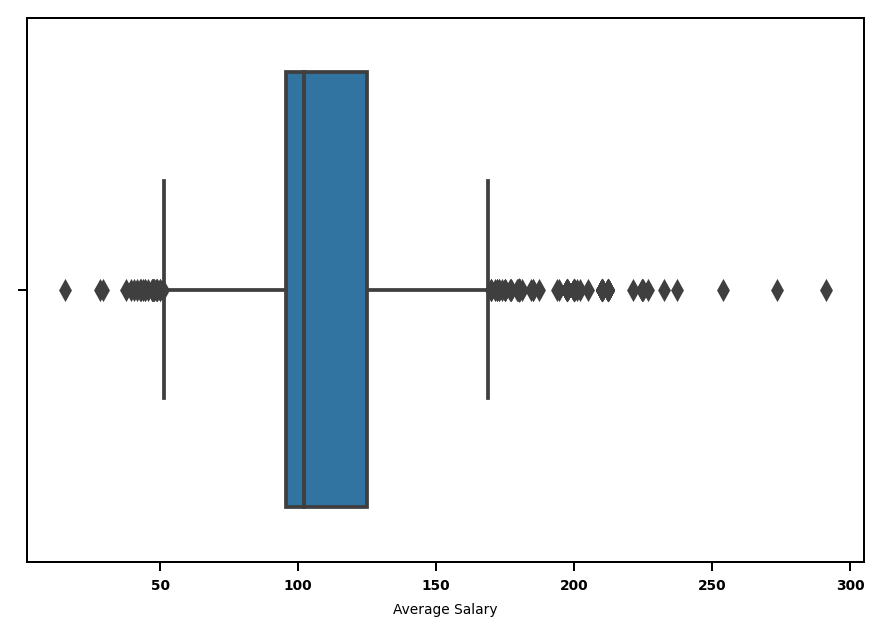

In [165]:
sns.boxplot(all_df['Average Salary'])

<AxesSubplot:xlabel='Average Salary', ylabel='Density'>

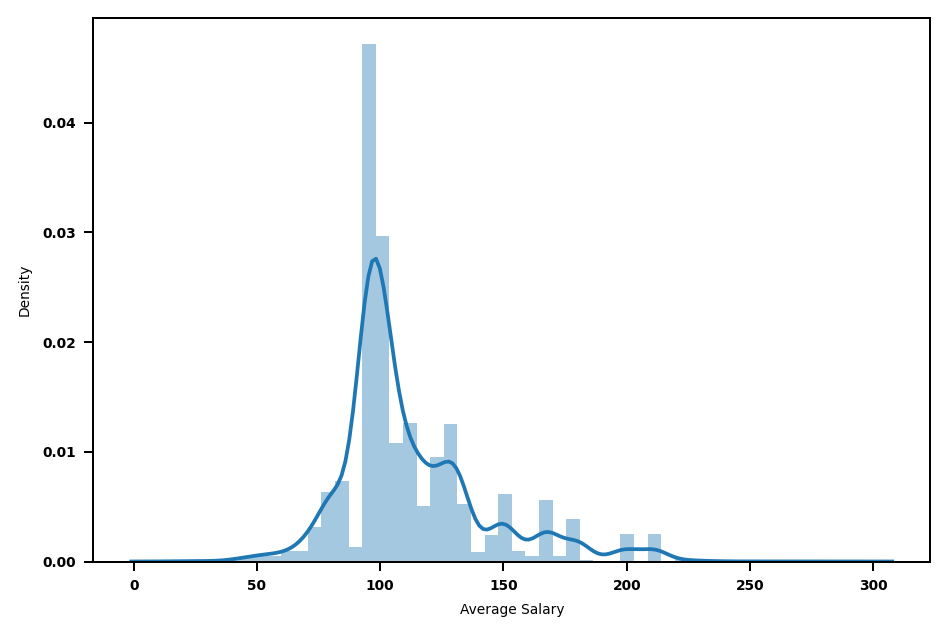

In [166]:
sns.distplot(all_df['Average Salary'])

In [167]:
q25, q75 = np.percentile(all_df['Average Salary'], 25), np.percentile(all_df['Average Salary'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
temp_all = all_df[(all_df['Average Salary'] > lower) & (all_df['Average Salary'] < upper)]

In [168]:
temp_all = all_df[(all_df['Average Salary'] > lower) & (all_df['Average Salary'] < upper)]

<AxesSubplot:xlabel='Average Salary', ylabel='Density'>

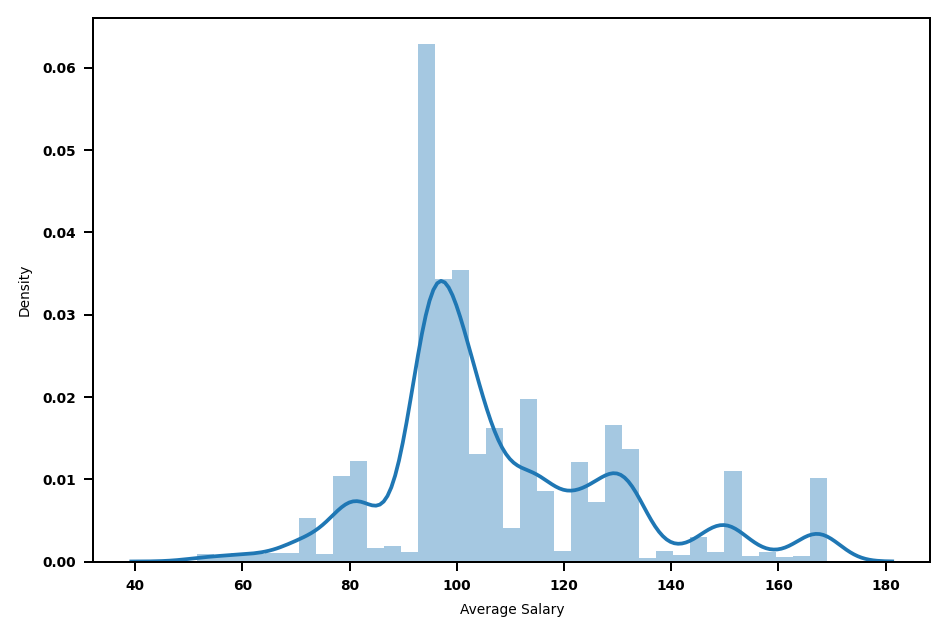

In [169]:
sns.distplot(temp_all['Average Salary'])

In [170]:
temp_all.to_csv('cleaned_no_outliers.csv', index=False)

In [171]:
all_df.to_csv('all_cleaned_data.csv', index=False)